In [11]:
#imports and data upload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor


sns.set()


df = pd.read_csv("../data/processed/data_for_model_engineered.csv")
df.head()


,Standort_ID,Datum,Koord_Ost,Koord_Nord,Velo,year,day_of_year,Niederschlag,Temperatur Durchschnitt,weekday,...,temp_feels,temp_sq,is_rain,heavy_rain,velo_roll3,velo_roll7,velo_lag1,velo_lag7,station_avg_traffic,location_cluster
0,60,2022-01-01,2682731,1247708,134.0,2022,1,0.0,2.6,5,...,2.60,6.76,0,0,1130.000000,1130.0,1130.0,1130.0,823.141573,0
1,60,2022-01-02,2682731,1247708,189.0,2022,2,0.0,4.9,6,...,4.90,24.01,0,0,1130.000000,1130.0,134.0,1130.0,823.141573,0
2,60,2022-01-03,2682731,1247708,676.0,2022,3,0.0,10.2,0,...,10.20,104.04,0,0,333.000000,1130.0,189.0,1130.0,823.141573,0
3,60,2022-01-04,2682731,1247708,646.0,2022,4,6.4,11.0,1,...,6.52,121.00,1,1,503.666667,1130.0,676.0,1130.0,823.141573,0
4,60,2022-01-05,2682731,1247708,518.0,2022,5,10.9,1.7,2,...,-5.93,2.89,1,1,613.333333,1130.0,646.0,1130.0,823.141573,0


In [2]:
# Definition of feature and target

TARGET = "Velo"

exclude = [
    "Velo",
    "Velo_log",       # nur falls vorhanden
    "Datum",          # rohes Datum nicht direkt ins Modell
    "Standort_ID",
    "Koord_Ost",
    "Koord_Nord",
    "year",
    "week",
    "quarter",
    # "day_of_year",
    "year_length",
]

features = [c for c in df.columns if c not in exclude]
print("Anzahl Features:", len(features))
features

len(features), features[:]


Anzahl Features: 19


(19,
 ['day_of_year',
  'Niederschlag',
  'Temperatur Durchschnitt',
  'weekday',
  'weekend',
  'is_holiday',
  'month',
  'sin_day',
  'cos_day',
  'temp_feels',
  'temp_sq',
  'is_rain',
  'heavy_rain',
  'velo_roll3',
  'velo_roll7',
  'velo_lag1',
  'velo_lag7',
  'station_avg_traffic',
  'location_cluster'])

# Train/Test Split

In [3]:
X = df[features]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((19039, 19), (4760, 19))

In [7]:
#helperfunction
def evaluate_model(name, y_true, y_pred, results_list):
    # MSE without squared-parameter (works in all sklearn versions)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    results_list.append({
        "model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
    })
    print(f"{name}: RMSE={rmse:.1f}, MAE={mae:.1f}, R²={r2:.3f}")

In [8]:
#Baseline: Mean Predictor
results = []

y_pred_baseline = np.ones_like(y_test) * y_train.mean()
evaluate_model("Baseline_Mean", y_test, y_pred_baseline, results)


Baseline_Mean: RMSE=1126.9, MAE=840.7, R²=-0.000


# Model 1: Linear Regression

In [12]:
lin_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

lin_pipe.fit(X_train, y_train)
y_pred_lin = lin_pipe.predict(X_test)

evaluate_model("LinearRegression", y_test, y_pred_lin, results)


LinearRegression: RMSE=286.0, MAE=194.7, R²=0.936


# Model 2: Random Forest

In [13]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

evaluate_model("RandomForest", y_test, y_pred_rf, results)


RandomForest: RMSE=227.0, MAE=134.1, R²=0.959


# Model 3: XGBoost

In [14]:
xgb = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

evaluate_model("XGBoost", y_test, y_pred_xgb, results)


XGBoost: RMSE=170.9, MAE=94.0, R²=0.977


In [ ]:
#Vergleich der Tabellen
results_df = pd.DataFrame(results)
results_df

,model,RMSE,MAE,R2
0,Baseline_Mean,1126.902108,840.713029,-0.000026
1,LinearRegression,286.045943,194.734895,0.935567
2,RandomForest,226.993617,134.128800,0.959424
3,XGBoost,170.890451,93.970699,0.977003


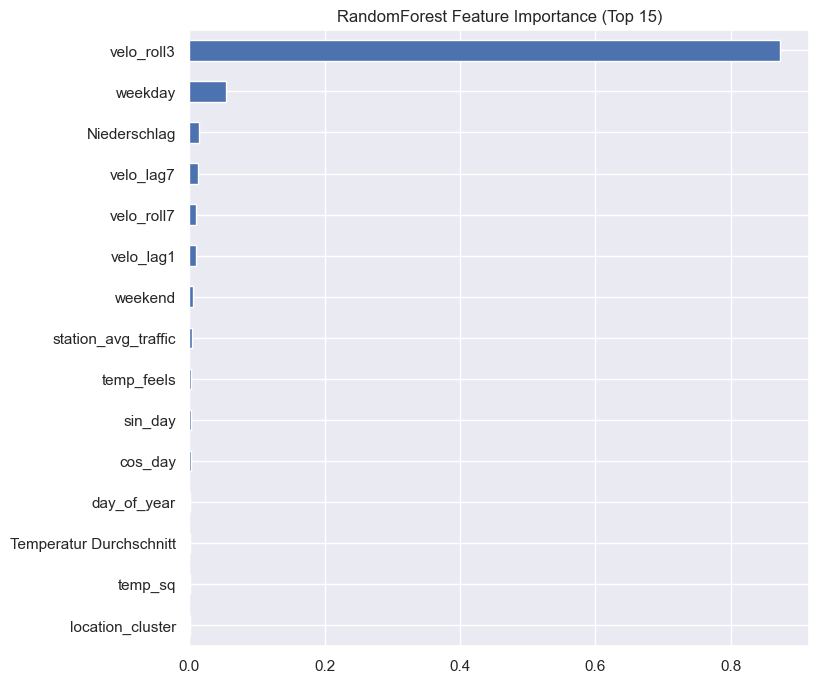

In [16]:
importances_rf = pd.Series(rf.feature_importances_, index=features)
importances_rf.sort_values().tail(15).plot(kind="barh", figsize=(8,8))
plt.title("RandomForest Feature Importance (Top 15)")
plt.show()


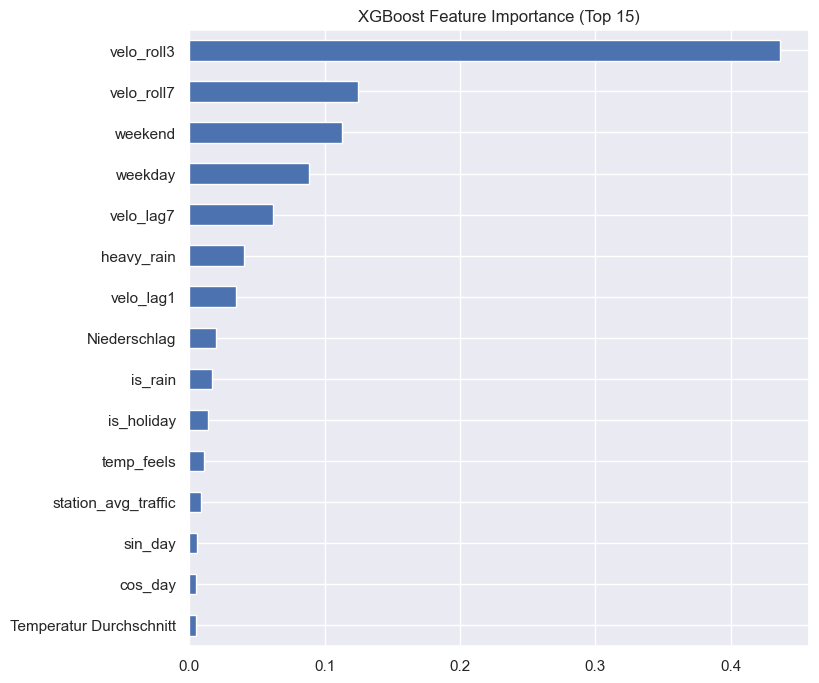

In [17]:
importances_xgb = pd.Series(xgb.feature_importances_, index=features)
importances_xgb.sort_values().tail(15).plot(kind="barh", figsize=(8,8))
plt.title("XGBoost Feature Importance (Top 15)")
plt.show()